Goal: diff hic (up down) pileup plot (centers)



In [185]:
import numpy as np
import pandas as pd
import hicstraw
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from matplotlib import rcParams

import re
import os

## hubs and hic data

In [186]:
# ! ls /home/qchen/PhD/ExhaustedT/Hic/results/hic_hicpro2juiceboxr |grep -v "dist"|grep "m.hic"

! ls /home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/ |grep  "allValidPairs.dist.KR.r10k.hic"

HL60_2d.allValidPairs.dist.KR.r10k.hic
HL60_4d.allValidPairs.dist.KR.r10k.hic
HL60_4h.allValidPairs.dist.KR.r10k.hic
HL60_Ctrl.allValidPairs.dist.KR.r10k.hic


In [187]:
! ls . |grep ".bed"

DIR_Within2anchor_asso_DEG_both_down_DIRs.bed
DIR_Within2anchor_asso_DEG_both_up_DIRs.bed


## take a look at  data

In [188]:
# hic = hicstraw.HiCFile("https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic")
hic_file = "/home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/HL60_2d.allValidPairs.dist.KR.r10k.hic"
hic_test = hicstraw.HiCFile(hic_file)



In [189]:
print(hic_test.getGenomeID())
print(hic_test.getResolutions())


hg19
[10000]


#### 

In [190]:
##### chrom_length = {}
for chrom in hic_test.getChromosomes():
    # print(chrom.name, chrom.length)
    chrom_length[chrom.name] = chrom.length
chrom_length 



{'1': 249250621,
 '2': 243199373,
 '3': 198022430,
 '4': 191154276,
 '5': 180915260,
 '6': 171115067,
 '7': 159138663,
 '8': 146364022,
 '9': 141213431,
 '10': 135534747,
 '11': 135006516,
 '12': 133851895,
 '13': 115169878,
 '14': 107349540,
 '15': 102531392,
 '16': 90354753,
 '17': 81195210,
 '18': 78077248,
 '19': 59128983,
 '20': 63025520,
 '21': 48129895,
 '22': 51304566,
 'X': 155270560,
 'ALL': 3095693,
 'Y': 59373566,
 'MT': 16569}

The "All" chromosome is a zoomed out all-by-all view that is used for Juicebox visualization. The remaining chromosomes are the actual ones used for any analysis.

In [ ]:

del chrom_length["ALL"]
# del chrom_length["All"]

del chrom_length["MT"]

del chrom_length["Y"]
chrom_length 

{'1': 249250621,
 '2': 243199373,
 '3': 198022430,
 '4': 191154276,
 '5': 180915260,
 '6': 171115067,
 '7': 159138663,
 '8': 146364022,
 '9': 141213431,
 '10': 135534747,
 '11': 135006516,
 '12': 133851895,
 '13': 115169878,
 '14': 107349540,
 '15': 102531392,
 '16': 90354753,
 '17': 81195210,
 '18': 78077248,
 '19': 59128983,
 '20': 63025520,
 '21': 48129895,
 '22': 51304566,
 'X': 155270560}

## define function for aggregated heatmap

In [195]:
chrom_length.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'])

In [ ]:

def Peak_50bin_aggre_heatmap(Peak, hic, chrom_length, norm, resolution):
    
    ## to speed up. only extract the Matrix from each chromosome once 
    peak_list=[]
    for chromsome in list(chrom_length.keys()):
        # print(chromsome)
        # chromsome = "chr19"

        # 1. extract the matrix
        matrix_temp = hic.getMatrixZoomData( chromsome, chromsome, "oe", norm, "BP", resolution)

        # 2. extract the Peak in the chromosome
        # pay speciall attention here, the chr in hic is just the number, but in the peak file, it has chr. need to keep consistent
        Peak_temp = Peak[Peak.iloc[:,0] == "chr"+chromsome]
        # print(Peak_temp.shape)
        
        # 3. go over every Peak+/-50binb and locate the bin and extraxt the 1*N matrix. (N is the chromosome length)
        for I in Peak_temp.index:
            Peak_pos = int(Peak_temp.loc[I,1]/resolution)*resolution
                
            if (Peak_pos - 50*resolution )> 0:
                bin1_temp = Peak_pos - 50*resolution
            else:
                bin1_temp = 1
                    
            bin2_temp = Peak_pos  + 50*resolution
            # Segment heatmap matrix   Peak +/-50 BIN
                
            numpy_matrix_temp = matrix_temp.getRecordsAsMatrix(bin1_temp, bin2_temp ,bin1_temp, bin2_temp)
            # print(numpy_matrix_temp.shape)
            
            ## save all the individual peak heatmap to a list !!!!------101 must be checked !!
            if (len(numpy_matrix_temp)==101):
                peak_list.append(numpy_matrix_temp)
            
        
    print(len(peak_list))
    return  sum(peak_list)/len(peak_list)

## run on the data

In [197]:

diffhic_path = './'

hic_path = '/home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/'
# ls diffhic_dict/home/qchen/PhD/Neu/OCEANC/Neu_H/hic_results/H_hicpro2juicebox/ |grep -v "dist"|grep ".hic"

In [ ]:

norm = "KR"
resolution = 10**4


In [ ]:

diffhic_Files = [f for f in sorted(os.listdir(diffhic_path)) if re.match(r'.*.bed', f)]
diffhic_Files 

['DIR_Within2anchor_asso_DEG_both_down_DIRs.bed',
 'DIR_Within2anchor_asso_DEG_both_up_DIRs.bed']

In [ ]:

Conditions= [x.split('.')[0] for x in diffhic_Files] 
Conditions

['DIR_Within2anchor_asso_DEG_both_down_DIRs',
 'DIR_Within2anchor_asso_DEG_both_up_DIRs']

In [ ]:
Conditions



['DIR_Within2anchor_asso_DEG_both_down_DIRs',
 'DIR_Within2anchor_asso_DEG_both_up_DIRs']

In [205]:
diffhic_dict = {}

for p in Conditions:
    diffhic_dict[p] = pd.read_csv(diffhic_path + p +".bed" , header=None, sep='\t')


In [206]:
[diffhic_dict[p].shape for p in diffhic_dict.keys()]

[(347, 3), (326, 3)]

In [207]:
list(diffhic_dict.keys())

['DIR_Within2anchor_asso_DEG_both_down_DIRs',
 'DIR_Within2anchor_asso_DEG_both_up_DIRs']

In [208]:
diffhic_dict[list(diffhic_dict.keys())[0]].head()

,0,1,2
0,chr1,8020000,8400000
1,chr1,15910000,16050000
2,chr1,18080000,18100000
3,chr1,22260000,22300000
4,chr1,28260000,28280000


In [214]:
# Hic_files = [f for f in os.listdir(hic_path) if re.match(r'.*.hic', f)]
Hic_files = [f for f in os.listdir(hic_path) if re.match(r'.*.\.allValidPairs.dist.KR.r10k.hic', f)]
Hic_files

['HL60_2d.allValidPairs.dist.KR.r10k.hic',
 'HL60_4h.allValidPairs.dist.KR.r10k.hic',
 'HL60_4d.allValidPairs.dist.KR.r10k.hic',
 'HL60_Ctrl.allValidPairs.dist.KR.r10k.hic']

In [215]:
myorder = [3,1,0,2]
Hic_files = [Hic_files[i] for i in myorder]
Hic_files

['HL60_Ctrl.allValidPairs.dist.KR.r10k.hic',
 'HL60_4h.allValidPairs.dist.KR.r10k.hic',
 'HL60_2d.allValidPairs.dist.KR.r10k.hic',
 'HL60_4d.allValidPairs.dist.KR.r10k.hic']

In [216]:
# MORE  simple and precise way 

Heatmaps = []
#  ---> load condition specific peaks
    
for H in Hic_files:
    print(H)
    #  ---> load corresponding hic data
    hic = hicstraw.HiCFile(hic_path + H )
    for P in diffhic_dict.keys():
        print(P) 
        #  ---> Peak_50bin_aggre_heatmap
        heatmap = Peak_50bin_aggre_heatmap(diffhic_dict[P], hic, chrom_length, norm, resolution)
        Heatmaps.append(heatmap)

HL60_Ctrl.allValidPairs.dist.KR.r10k.hic
DIR_Within2anchor_asso_DEG_both_down_DIRs
347
DIR_Within2anchor_asso_DEG_both_up_DIRs
326
HL60_4h.allValidPairs.dist.KR.r10k.hic
DIR_Within2anchor_asso_DEG_both_down_DIRs
347
DIR_Within2anchor_asso_DEG_both_up_DIRs
326
HL60_2d.allValidPairs.dist.KR.r10k.hic
DIR_Within2anchor_asso_DEG_both_down_DIRs
347
DIR_Within2anchor_asso_DEG_both_up_DIRs
326
HL60_4d.allValidPairs.dist.KR.r10k.hic
DIR_Within2anchor_asso_DEG_both_down_DIRs
347
DIR_Within2anchor_asso_DEG_both_up_DIRs
326


## draw heatmaps
Take a look at the global trend and then choose the vmax

In [217]:
NumHic = len(Hic_files)
NumPeak = len(Conditions)
print(NumHic,NumPeak)

4 2


In [238]:
heatmaps_reverse = []

for i in range(NumPeak):
    for j in [n*NumPeak for n in list(range(NumHic)) ]:
        heatmaps_reverse.append(Heatmaps[i+j])
len(heatmaps_reverse)

8

In [240]:
scale = [3.5,3.5] # customized
lis = [[i]*NumHic for i in scale ]
## list of list to one flat list

# method1
scale_all1 = sum(lis, []) 

# method2 
scale_all2 =list(np.concatenate(lis))


In [241]:
norm_factor = [1]*NumHic
lis = [[i]*NumPeak for i in norm_factor ]
## list of list to one flat list

# method1
norm_factor_all1 = sum(lis, [])

# method2 
norm_factor_all2 =list(np.concatenate(lis))
len(norm_factor_all2)

8

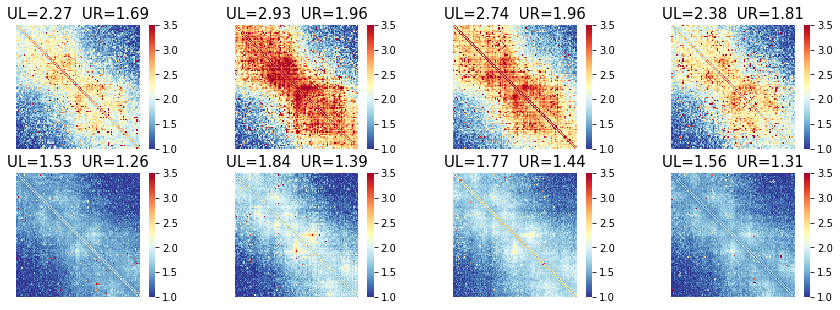

In [244]:


rcParams['figure.figsize'] =15,5

fig, axs = plt.subplots(NumPeak,NumHic, sharey=True)

# # scale = [1.8]*NumPeak
scale = [3.5,3.5]
# norm_factor = [1]*NumHic

for i in range(NumPeak*NumHic):
        heatmap = heatmaps_reverse[i]
        Max = heatmap.max(axis = 0).max()
        mean1 = np.round(np.mean(heatmap[0:50,0:50]),2)
        mean2 = np.round(np.mean(heatmap[0:50,51:100]),2)
        # plt.matshow(heatmap, cmap=REDMAP, vmin=0, vmax=Max)
        # sns.heatmap(heatmap, cmap="RdYlBu_r", vmin=1, vmax=scale[i],xticklabels=False, yticklabels=False,ax=axs[i])
        # print(i//4,i%4)
        sns.heatmap(heatmap*norm_factor_all1[i], cmap="RdYlBu_r", vmin=1, vmax= scale_all1[i] ,xticklabels=False, yticklabels=False,ax=axs[i//NumHic,i%NumHic],square=True)
        axs[i//NumHic,i%NumHic].set_title('UL='+str(mean1) + '  ' + 'UR='+str(mean2), fontsize =15)
        
        
# plt.show()

plt.savefig("./diffhic_pileup_plot_reversed.pdf")  
    